# Getting Treatment

### by Kaitlyn Keil
### March 2017

<a href = http://www.icpsr.umich.edu/icpsrweb/ICPSR/series/64>Link to NSDUH Website</a>

<a href = http://www.icpsr.umich.edu/icpsrweb/ICPSR/ssvd/studies/36361/variables>Variable list link</a>

<a href = https://github.com/KaitlynKeil/ThinkStats2/blob/master/code/reports/report2.md>Corresponding Article</a>

In [203]:
""" This file contains code used to analyze the
2014 NSDUH Survey, the information for which can be found at this link:
http://www.icpsr.umich.edu/icpsrweb/ICPSR/series/64

The following packages are required to run this code.
"""

from __future__ import print_function, division
import pandas as pd

import sys
import numpy as np
import thinkstats2
import thinkplot
import matplotlib.pyplot as plt
from operator import itemgetter
from cycler import cycler

from collections import defaultdict, Counter
import survival
import statsmodels.formula.api as smf

In [117]:
def ReadNSDUH():
    """ Reads the NSDUH file.

    returns a Dataframe
    """
    nsduh = pd.read_stata('reports/report2data/ICPSR_36361/DS0001/36361-0001-Data.dta',convert_categoricals=False, convert_missing=False)
    return nsduh

#Row-wise minimum: check pandas, otherwise convert to NP array, check min over an axis, assign to new column
#  min(axis=1)

In [118]:
def CleanData(df):
    """ Replaces the error codes for the necessary values.
    Due to the high number of variables in the survey,
    only the ones I intend to use are cleaned.
    Creates four new columns for analysis purposes.
    """
    na_vals = range(981,1000)#[981 , 989 , 991 , 994 , 997 , 998 , 999]
    ev_vals = []
    df.TXALONAG.replace(na_vals, np.nan, inplace=True)
    df.TXDRONAG.replace(na_vals, np.nan, inplace=True)
    df.TXALCDAG.replace(na_vals, np.nan, inplace=True)
    df.TXDRGAAG.replace(na_vals, np.nan, inplace=True)
    df.TXYALAGE.replace(na_vals, np.nan, inplace=True)
    df.TXYALDRG.replace(na_vals, np.nan, inplace=True)
    df.TXYALDAG.replace(na_vals, np.nan, inplace=True)
    df.TXYDRAGE.replace(na_vals, np.nan, inplace=True)
    df.TXYDRALC.replace(na_vals, np.nan, inplace=True)
    df.TXYDRAAG.replace(na_vals, np.nan, inplace=True)
    df.TXYADAAG.replace(na_vals, np.nan, inplace=True)
    df.TXYADDAG.replace(na_vals, np.nan, inplace=True)
    
    df.CABNGAGE.replace(na_vals, np.nan, inplace=True)
    df.CIGAGE.replace(na_vals, np.nan, inplace=True)
    df.SUMAGE.replace(na_vals, np.nan, inplace=True)
        
    year_nas = [9985, 9989, 9991, 9994, 9997, 9998, 9999]
    df.CABNGYFU.replace(year_nas, np.nan, inplace=True)
    df.SUMYFU.replace(year_nas, np.nan, inplace=True)
    df.CIGYFU.replace(year_nas, np.nan, inplace=True)
    
    #df['agetreatment']=df.TXDRGAAG
    #df['agedruguse']=df.SUMAGE
    #df['yearsofuseTX']=df.agetreatment-df.agedruguse
    #df['yearssincefirst']=2014-df.SUMYFU
    
    tx_temp = df.loc[:,['TXALONAG','TXDRONAG','TXALCDAG',
                 'TXDRGAAG','TXYALAGE',
                 'TXYALDAG','TXYDRAGE',
                 'TXYDRAAG','TXYADAAG','TXYADDAG']]
    dr_temp = df.loc[:,['CABNGAGE','CIGAGE', 'SUMAGE']]
    yr_temp = df.loc[:,['CIGYFU', 'SUMYFU', 'CABNGYFU']]
    
    df['agetreatment']=tx_temp.min(axis = 1)
    df['agedruguse']=dr_temp.min(axis = 1)
    df['yearsofuseTX']=df.agetreatment-df.agedruguse
    df['yearssincefirst']=2014-yr_temp.min(axis=1)
    df["treated"] = (df.TXEVER==1).astype(int)
    df['zeros'] = 0

In [119]:
def FillMissingOngoing(years_use):
    """Fills missing values with an exponentially weighted moving average.

    Resulting DataFrame has new columns 'ewma' and 'resid'.

    years_use: DataFrame of ages
    span: window size (sort of) passed to ewma

    returns: new DataFrame of daily prices
    """
    #ids = pd.years_range(years_use.index.min(), years_use.index.max())
    #reindexed = years_use.reindex(ids)
    
    fake_data = years_use.zeros + thinkstats2.Resample(years_use.yearssincefirst, len(years_use))
    years_use.yearssincefirst.fillna(fake_data, inplace=True)
    
    return years_use

def FillMissingComplete(years_use):
    """Fills missing values with an exponentially weighted moving average.

    Resulting DataFrame has new columns 'ewma' and 'resid'.

    years_use: DataFrame of ages
    span: window size (sort of) passed to ewma

    returns: new DataFrame of daily prices
    """
    #ids = pd.years_range(years_use.index.min(), years_use.index.max())
    #reindexed = years_use.reindex(ids)

    fake_data = years_use.zeros + thinkstats2.Resample(years_use.yearsofuseTX, len(years_use))
    years_use.yearsofuseTX.fillna(fake_data, inplace=True)

    #years_use['ewma'] = ewma
    years_use['resid'] = years_use.yearsofuseTX - mean
    return years_use

In [120]:
def EstimateHazardFunction(complete, ongoing, label='', verbose=False):
    """Estimates the hazard function by Kaplan-Meier.

    http://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator

    complete: list of complete lifetimes
    ongoing: list of ongoing lifetimes
    label: string
    verbose: whether to display intermediate results
    """
    
    if np.sum(np.isnan(complete)):
        raise ValueError("complete contains NaNs")
    if np.sum(np.isnan(ongoing)):
        raise ValueError("ongoing contains NaNs")

    hist_complete = Counter(complete)
    hist_ongoing = Counter(ongoing)

    ts = list(hist_complete | hist_ongoing)
    ts.sort()

    at_risk = len(complete) + len(ongoing)

    lams = pd.Series(index=ts)
    for t in ts:
        ended = hist_complete[t]
        censored = hist_ongoing[t]

        lams[t] = ended / at_risk
        if verbose:
            print(t, at_risk, ended, censored, lams[t])
        at_risk -= ended + censored

    return survival.HazardFunction(lams, label=label)

In [121]:
# Read and clean the data
nsduh = ReadNSDUH()
CleanData(nsduh)

In [122]:
ongoing = FillMissingOngoing(nsduh[nsduh.TXEVER == 2])
#f_ongoing = FillMissingOngoing(ongoing)
complete = FillMissingComplete(nsduh[nsduh.TXEVER == 1])
#f_complete = FillMissingComplete(complete)

/home/kaitlyn/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/kaitlyn/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [123]:
# Finding the percentage of people who use drugs or alcohol and have gotten treatment

hist_treatment = thinkstats2.Hist(nsduh.TXEVER)
# 1 indicates receiving treatment, 2 indicates never having received treatment
print((hist_treatment[1]/(hist_treatment[1]+hist_treatment[2]))*100)

7.41259405189


In [124]:
len(ongoing[np.isnan(ongoing.yearssincefirst)].yearssincefirst)
len(complete[np.isnan(complete.yearsofuseTX)].yearsofuseTX)

45

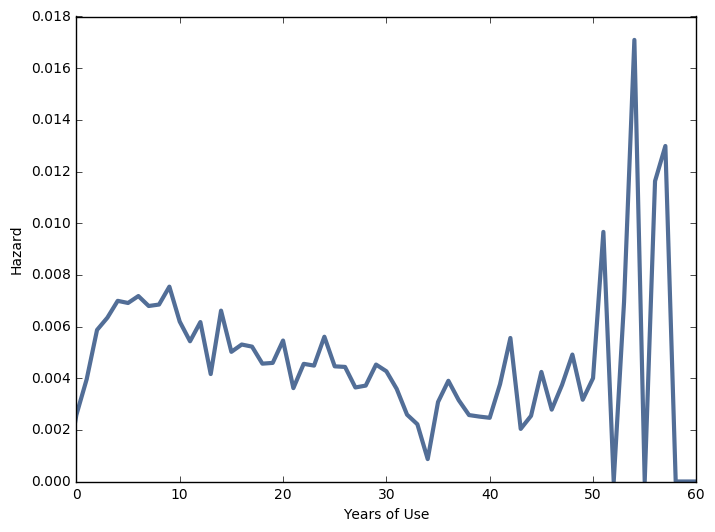

In [125]:
# Using Kaplan-Meier Estimation, find the hazard function.
# This allows us to account for incomplete cases (no treatment yet)

hf = EstimateHazardFunction(complete.yearsofuseTX.dropna(), ongoing.yearssincefirst.dropna())
thinkplot.Plot(hf)
thinkplot.Config(xlabel='Years of Use',
                 xlim=[0,60],
                 #ylim=[0,.03],
                 ylabel='Hazard')
thinkplot.Show()

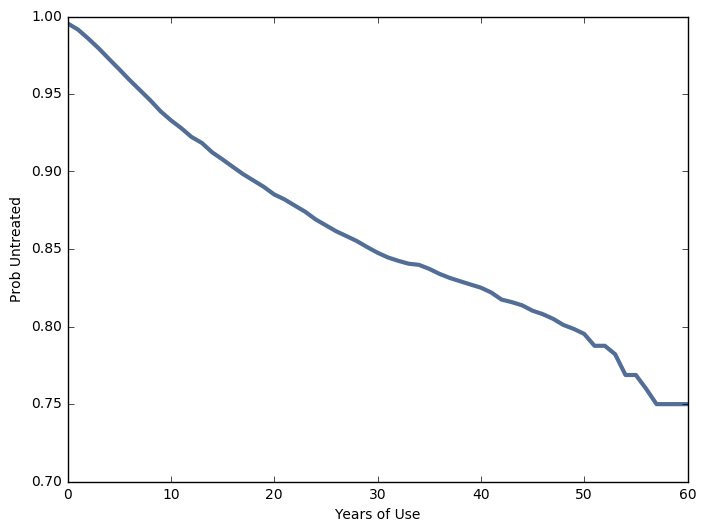

In [126]:
# Use the hazard function to create the survival curve

sf = hf.MakeSurvival()
thinkplot.Plot(sf)
thinkplot.Config(xlabel='Years of Use',
                 xlim = [0, 60],
                 ylabel='Prob Untreated')

thinkplot.Show()

In [127]:
# Define functions to plot the different survival curves for each income group.
# POVERTY2
#  1 indicates below poverty line (pl)
#  2 indicates up to 2pl income
#  3 indicates >2pl income

def AddLabelsByIncome(groups, **options):
    """Draws fake points in order to add labels to the legend.

    groups: GroupBy object
    """
    labels = {1:'Below Poverty Line', 2:'Middle Income', 3:'Double and Above', -9:'College Student'}
    thinkplot.PrePlot(len(groups))
    for name, _ in groups:
        thinkplot.Plot([15], [1], label=labels[name], **options)

def EstimateGroupSurvival(resp):
    """Estimates the survival curve.

    resp: DataFrame of respondents

    returns: pair of HazardFunction, SurvivalFunction
    """
    # NOTE: Filling missing values would be better than dropping them.
    ongoing = FillMissingOngoing(resp[resp.TXEVER == 2])
    complete = FillMissingComplete(resp[resp.TXEVER == 1])

    hf = EstimateHazardFunction(complete.yearsofuseTX.dropna(), ongoing.yearssincefirst.dropna())
    sf = hf.MakeSurvival()

    return hf, sf

def PlotPredictionsByIncome(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    hfs = []
    for _, group in groups:
        hf, sf = EstimateGroupSurvival(group)
        hfs.append(hf)

    thinkplot.PrePlot(len(hfs))
    for i, hf in enumerate(hfs):
        if i > 0:
            hf.Extend(hfs[i-1])
        sf = hf.MakeSurvival()
        thinkplot.Plot(sf, **options)

/home/kaitlyn/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/kaitlyn/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


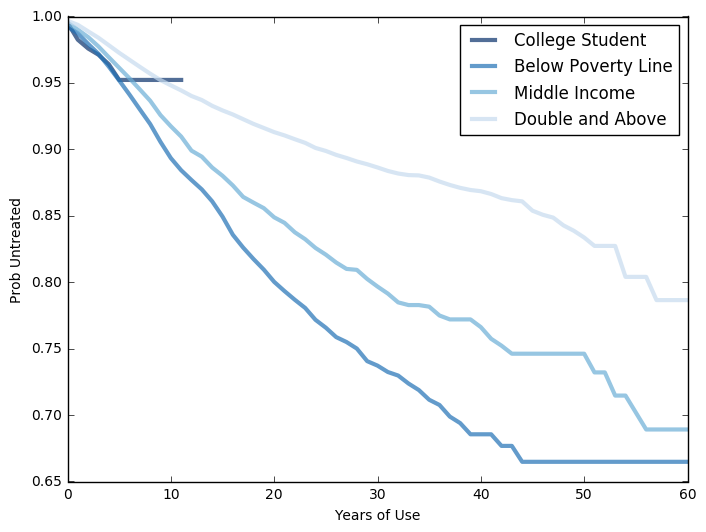

In [128]:
groups = nsduh.groupby('POVERTY2')
PlotPredictionsByIncome(groups)

AddLabelsByIncome(groups, alpha=0.7)
thinkplot.Config(xlabel='Years of Use',
                 xlim = [0, 60],
                 ylabel='Prob Untreated')
                 #ylim=[0.8, 1])
thinkplot.Show()

In [207]:
import re

def GoMining(df):
    """Searches for variables that predict years of use before treatment.

    df: DataFrame of nsduh

    returns: list of (rsquared, variable name) pairs
    """
    variables = []
    for name in df.columns:
        try:
            if df[name].var() < 1e-7:
                continue

            formula = 'TXEVER ~ ' + name
            #formula = formula.encode('ascii')

            model = smf.ols(formula, data=df)
            if model.nobs < len(df)/2:
                continue

            results = model.fit()
        except (ValueError, TypeError):
            continue

        variables.append((results.rsquared, name))

    return variables

def MiningReport(variables, n=[0,30]):
    """Prints variables with the highest R^2.

    t: list of (R^2, variable name) pairs
    n: number of pairs to print
    """
    variables.sort(reverse=True)
    for r2, name in variables[n[0]:n[1]]:
        key = re.sub('_r$', '', name)
        print(name, r2)

In [209]:
# Looking at the variables most likely to indicate whether or not someone has had treatment,
#  the main ones that popped up were those stating someone needed treatment (ND variables).
#  This is not particularly informative.
variables = GoMining(nsduh)
MiningReport(variables)

NDMRHNDL 0.625860943238
NDMRJOB 0.62522490055
NDTMROTH 0.624608359851
NDTMRCOC 0.624608359851
NDMRNBR 0.624590109473
NDMRWHER 0.623956566315
NDMRSOR 0.623956566315
NDMRNTSP 0.623324267403
NDMRTYPE 0.623324267403
NDMRLMCV 0.622693209075
NDTMRMJ 0.622081539393
NDTMRHER 0.622081539393
NDTMRANL 0.620825543941
NDMRREDY 0.620181308884
NDMRNHCV 0.618310232606
NDTMRALC 0.612779853004
NDTMREFT 0.59836898535
TXYRERAD 0.592541374464
ALCAFU2 0.585546922191
TXYRDCAD 0.57200908168


In [213]:
# In order to see past this, remove the ND variables
variables.sort(reverse=True)
for r2, name in variables[:100]:
    if name[0:2]!='ND':
        key = re.sub('_r$', '', name)
        print(name, r2)

TXEVER 1.0
TX12MSHG 0.987383483325
ALCFLAG 0.851266614729
IRALCYFU 0.851262026038
IRALCAGE 0.851207791369
ALCREC 0.851182401865
IIALCAGE 0.848694168195
ALLAST3 0.845721518697
CABNGEV 0.842354135095
ALCYRBFR 0.835108268928
IIALCYFU 0.826423953574
IRALCRC 0.820666838877
ALCTRY 0.811478686852
TXYRJLAD 0.685810717215
TXDRONEV 0.659957728248
TXYRERAD 0.592541374464
ALCAFU2 0.585546922191
TXYRDCAD 0.57200908168
ALCAFU3 0.567901890091
ILORALC 0.564164015389
FUALC21 0.519194887287
ALCAFU 0.515432404511
HPALCNOT 0.51048175239
DRIVALD2 0.510037294382
ALCYR 0.502370595166
IIALCFY 0.502326831783
II2ALCFY 0.500644995317
TXYROTAD 0.49503105815
IRALCFY 0.488652016841
ALFRAME3 0.481493195943
ALBSTWAY 0.477042554948
TOTDRINK 0.474385210934
TXPYSP2 0.472164200092
ALCYRTOT 0.469233999085
DRIVALC2 0.464063546403
TXYRHPAD 0.456897409665
DRVAONLY 0.445453215015
TXYRINAD 0.422169338694
TXYRMHAD 0.40783804739
TXPYFRE 0.378604534761
ALCYDAYS 0.367574540317
ILTOALMN 0.35547730523
CIGOFRSM 0.340247676808
CIGWILY

In [211]:
# Picking out a few of the interesting ones, we see that DRIVALC2 (respondant has driven while under the influence)
#  has a negative coefficient, suggesting lower numbers tie to the respondant having had treatment. DRIVALC2=1 
#  means the respondant has driven under the influence, with 2 and higher referencing no.

formula = 'treated ~ DRIVALC2'

model = smf.logit(formula, data=nsduh)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.212715
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                treated   No. Observations:                55271
Model:                          Logit   Df Residuals:                    55269
Method:                           MLE   Df Model:                            1
Date:                Thu, 23 Mar 2017   Pseudo R-squ.:                 0.02081
Time:                        21:36:09   Log-Likelihood:                -11757.
converged:                       True   LL-Null:                       -12007.
                                        LLR p-value:                1.080e-110
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -1.8280      0.046    -39.336      0.000        -1.919    -1.737
DRIVALC2      -0.4014      0.019    -21.376      0.000        -0.438    -0.365
==============================================================================
"""

In [214]:
# Similarly to above, ALCAFU3 (which corresponds to the age the person started drinking alcohol) has a negative
#  coefficient. As lower numbers mean a lower starting age, this suggests that those who start drinking young
#  may be more likely to receive treatment.

formula = 'treated ~ ALCAFU3'

model = smf.logit(formula, data=nsduh)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.192848
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                treated   No. Observations:                55271
Model:                          Logit   Df Residuals:                    55269
Method:                           MLE   Df Model:                            1
Date:                Thu, 23 Mar 2017   Pseudo R-squ.:                  0.1123
Time:                        21:39:56   Log-Likelihood:                -10659.
converged:                       True   LL-Null:                       -12007.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.9112      0.040    -22.944      0.000        -0.989    -0.833
ALCAFU3       -0.8213      0.019    -42.525      0.000        -0.859    -0.783
==============================================================================
"""

In [216]:
# Returning to our income brackets, we see that, once again and as we observed, those in poverty are actually
#  more likely to receive treatment (lower numbers tie to low income, and the coefficient is negative).
#  However, this effect is much smaller (seen by the pseudo R^2 value) than the two previous variables.
formula = 'treated ~ POVERTY2'

model = smf.logit(formula, data=nsduh)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.217162
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                treated   No. Observations:                55271
Model:                          Logit   Df Residuals:                    55269
Method:                           MLE   Df Model:                            1
Date:                Thu, 23 Mar 2017   Pseudo R-squ.:               0.0003389
Time:                        21:44:56   Log-Likelihood:                -12003.
converged:                       True   LL-Null:                       -12007.
                                        LLR p-value:                  0.004333
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -2.7351      0.032    -84.447      0.000        -2.799    -2.672
POVERTY2      -0.0357      0.012     -2.967      0.003        -0.059    -0.012
==============================================================================
"""